# Hard magnet tutorial

## Introduction

- In this notebook we explore hard magnet properties such as Hc as function of temperature for Fe16N2.
- We query databases to get temperature-dependent inputs for micromagnetic simulations from DFT and spin dynamics simulations
- We run hysteresis simulations and compute derived quantities.

Requirements:
- Software: `mammos`, `esys-escript`
- Basic understanding of [mammos-units](https://mammos-project.github.io/mammos/examples/mammos-units/quickstart.html) and [mammos-entity](https://mammos-project.github.io/mammos/examples/mammos-entity/quickstart.html)

The MODA diagram is provided at the bottom of the notebook.

In [1]:
%config InlineBackend.figure_format = "retina"

import math

import mammos_analysis
import mammos_dft
import mammos_entity as me
import mammos_mumag
import mammos_spindynamics
import mammos_units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colormaps

In [2]:
# Allow convenient conversions between A/m and T
u.set_enabled_equivalencies(u.magnetic_flux_field());

## DFT data: magnetization and anisotropy at zero Kelvin
The first step loads spontaneous magnetization `Ms_0` and the uniaxial anisotropy constant `K1_0` from a database of DFT calculations (at T=0K).

We can use the `print_info` flag to trigger printing of crystallographic information.

In [3]:
results_dft = mammos_dft.db.get_micromagnetic_properties("Fe16N2", print_info=True)

Found material in database.

Chemical Formula: Fe16N2
Space group name: P42/mnm
Space group number: 136
Cell length a: 8.78 Angstrom
Cell length b: 8.78 Angstrom
Cell length c: 12.12 Angstrom
Cell angle alpha: 90.0 deg
Cell angle beta: 90.0 deg
Cell angle gamma: 90.0 deg
Cell volume: 933.42 Angstrom3
ICSD_label: 
OQMD_label:

In [4]:
results_dft

MicromagneticProperties(Ms_0=SpontaneousMagnetization(value=1671126.902464901, unit=A / m), K1_0=UniaxialAnisotropyConstant(value=1100000.0, unit=J / m3))

In [5]:
results_dft.Ms_0

SpontaneousMagnetization(value=1671126.902464901, unit=A / m)

In [6]:
results_dft.K1_0

UniaxialAnisotropyConstant(value=1100000.0, unit=J / m3)

## Temperature-dependent magnetization data from spindynamics database lookup
In the second step we use a spin dynamics calculation database to load data for the temperature-dependent magnetization.

In [7]:
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetization("Fe16N2")

We can visualize the pre-computed data using `.plot`.

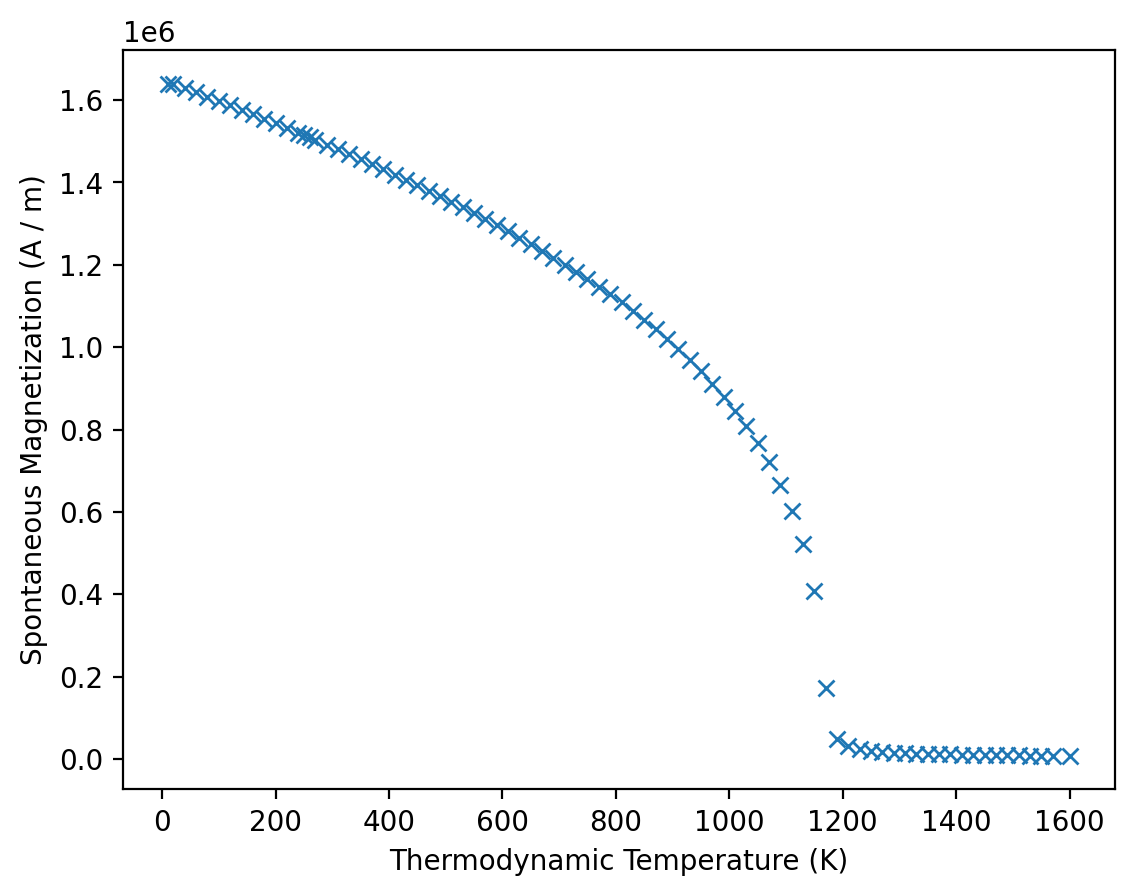

In [8]:
results_spindynamics.plot();

We can access `T` and `Ms` and get `mammos_entity.Entity` objects:

In [9]:
results_spindynamics.T

ThermodynamicTemperature(value=
[  10.   20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.
  240.  250.  260.  270.  290.  310.  330.  350.  370.  390.  410.  430.
  450.  470.  490.  510.  530.  550.  570.  590.  610.  630.  650.  670.
  690.  710.  730.  750.  770.  790.  810.  830.  850.  870.  890.  910.
  930.  950.  970.  990. 1010. 1030. 1050. 1070. 1090. 1110. 1130. 1150.
 1170. 1190. 1210. 1230. 1250. 1270. 1290. 1310. 1330. 1350. 1370. 1390.
 1410. 1430. 1450. 1470. 1490. 1510. 1530. 1550. 1570. 1600.],
 unit=K)

In [10]:
results_spindynamics.Ms

SpontaneousMagnetization(value=
[1639272.04060506 1639375.49131807 1629109.99748864 1618804.71492344
 1608308.44642653 1597692.8117223  1587021.47278799 1576206.89440489
 1565368.44278034 1554346.96297122 1543229.99019625 1531906.11599527
 1520542.4530585  1514956.11455598 1509250.40984613 1503385.5501932
 1491950.26753205 1479981.81581153 1467981.53310241 1456148.36308352
 1444132.16488009 1431606.67085875 1418874.2754114  1405958.85177949
 1393528.85072402 1380183.70874576 1366997.7217106  1353159.19940876
 1339583.28276302 1325235.46464328 1311126.37893819 1296293.13824202
 1281237.08062553 1265600.10746675 1250249.61320554 1234525.10482806
 1217774.04706764 1200091.93289013 1183277.21315247 1165443.90177902
 1146377.13959661 1128058.40564674 1108681.2913253  1086869.10637455
 1065781.07641488 1044048.46893568 1020732.26977272  995935.929639
  969261.5611768   942356.41804711  911663.38727184  878965.00421361
  844937.67738056  808204.71651495  766450.41719479  720597.87809002
  664

We can get also the data in the form of a `pandas.DataFrame`, which only contains the values in SI units:

In [11]:
results_spindynamics.dataframe.head()

,T,Ms
0,10.0,1.639272e+06
1,20.0,1.639375e+06
2,40.0,1.629110e+06
3,60.0,1.618805e+06
4,80.0,1.608308e+06


## Calculate micromagnetic intrinsic properties using Kuz’min formula

- We use Kuz’min equations to compute Ms(T), A(T), K1(T)
- Kuz’min, M.D., Skokov, K.P., Diop, L.B. et al. Exchange stiffness of ferromagnets. Eur. Phys. J. Plus 135, 301 (2020). https://doi.org/10.1140/epjp/s13360-020-00294-y
- Additional details about inputs and outputs are available in the [API reference](https://mammos-project.github.io/mammos/api/mammos_analysis.kuzmin.html#mammos_analysis.kuzmin.kuzmin_formula)

In [12]:
results_kuzmin = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
    K1_0=results_dft.K1_0,
)

The `plot` method of the returned object can be used to visualize temperature-dependence of all three quantities. The temperature range matches that of the fit data:

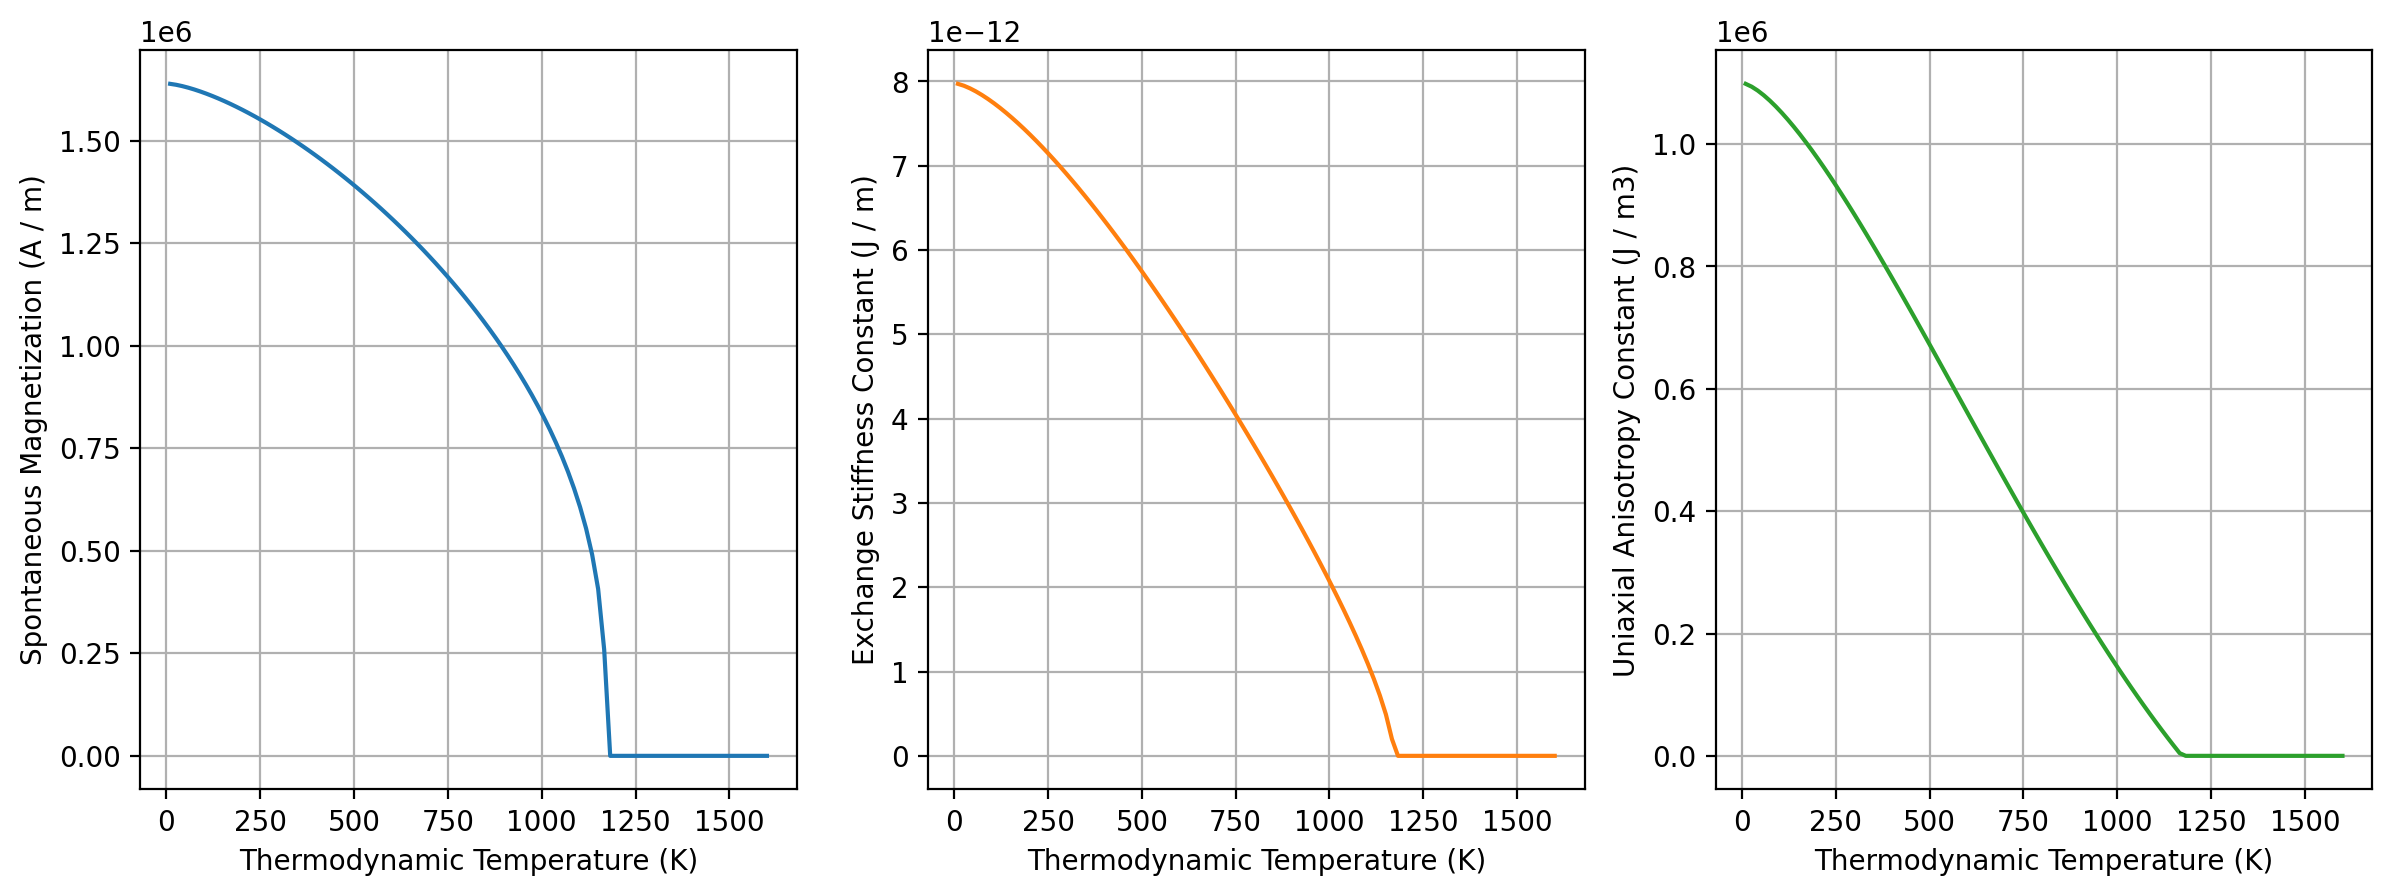

In [13]:
results_kuzmin.plot();

In [14]:
results_kuzmin

KuzminResult(Ms=Ms(T), A=A(T), Tc=CurieTemperature(value=1172.0457204795637, unit=K), s=<Quantity 1.68813857>, K1=K1(T))

- The attributes `Ms`, `A` and `K1` provide fit results as function of temperature. They each have a `plot` method.
- `Tc` is the fitted Curie temperature.
- `s` is a fit parameter in the Kuzmin equation.

To visually assess the accuracy of the fit, we can combine the `plot` methods of `results_kuzmin.Ms` and `results_spindynamics`:

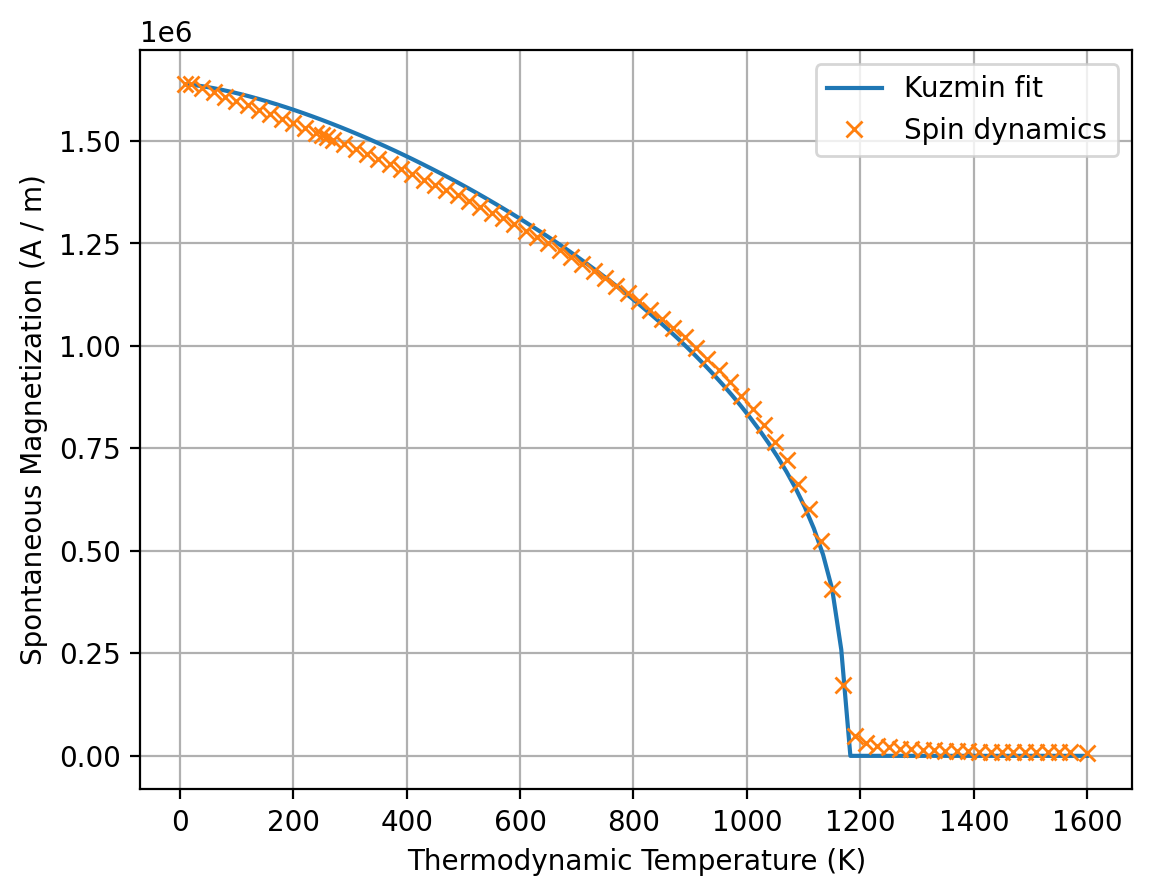

In [15]:
ax = results_kuzmin.Ms.plot(label="Kuzmin fit")
results_spindynamics.plot(ax=ax, label="Spin dynamics");

To get inputs for the micromagnetic simulation at a specific temperature we call the three attributes `Ms`, `A` and `K1`. We can pass a `mammos_entity.Entity`, an `astropy.units.Quantity` or a number:

In [16]:
temperature = me.T(300)
temperature

ThermodynamicTemperature(value=300.0, unit=K)

In [17]:
results_kuzmin.Ms(temperature)  # Evaluation with Entity

SpontaneousMagnetization(value=1524422.5569099565, unit=A / m)

In [18]:
results_kuzmin.A(300 * u.K)  # Evaluation with Quantity

ExchangeStiffnessConstant(value=6.90010473546342e-12, unit=J / m)

In [19]:
results_kuzmin.K1(300)  # Evaluation with number

UniaxialAnisotropyConstant(value=884617.8319031609, unit=J / m3)

## Run micromagnetic simulation to compute hysteresis loop
- We now compute a hysteresis loop (using a finite-element micromagnetic simulation) with the material parameters we have obtained.
- We simulate a 20x20x20 nm cube for which a pre-defined mesh is available.
- Additional documentation of this step is available [this notebook](https://mammos-project.github.io/mammos/examples/mammos-mumag/quickstart.html).

In [20]:
results_hysteresis = mammos_mumag.hysteresis.run(
    mesh_filepath=mammos_mumag.mesh.CUBE_20_nm,
    Ms=results_kuzmin.Ms(temperature),
    A=results_kuzmin.A(temperature),
    K1=results_kuzmin.K1(temperature),
    hstart=(1.5 * u.T).to(u.A / u.m),
    hfinal=(-1.5 * u.T).to(u.A / u.m),
    hnsteps=30,
)

The returned `results_hysteresis` object provides a `plot` method to visualize the computed data. `mammos_mumag.hysteresis` only computes half a hysteresis loop, going from `hstart` to `hfinal`. To show a full loop this function mirrors the computed data and plots it twice:

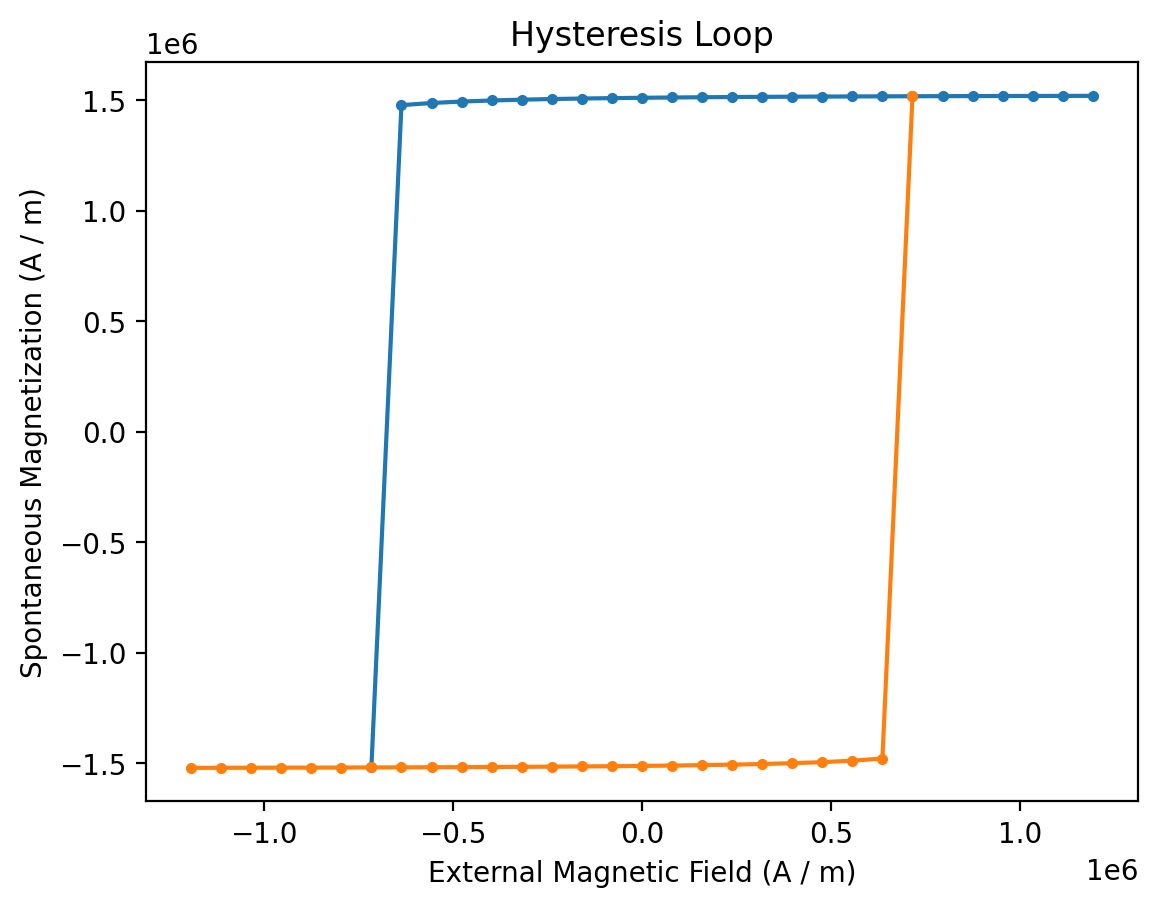

In [21]:
results_hysteresis.plot(marker=".");  # blue: simulation output, orange: mirrored data

The result object provides access to `H` and `M`:

In [22]:
results_hysteresis.H

ExternalMagneticField(value=
[ 1.19366207e+06  1.11408460e+06  1.03450713e+06  9.54929658e+05
  8.75352187e+05  7.95774715e+05  7.16197244e+05  6.36619772e+05
  5.57042301e+05  4.77464829e+05  3.97887358e+05  3.18309886e+05
  2.38732415e+05  1.59154943e+05  7.95774715e+04 -1.54610297e-10
 -7.95774715e+04 -1.59154943e+05 -2.38732415e+05 -3.18309886e+05
 -3.97887358e+05 -4.77464829e+05 -5.57042301e+05 -6.36619772e+05
 -7.16197244e+05],
 unit=A / m)

In [23]:
results_hysteresis.M

SpontaneousMagnetization(value=
[ 1520754.32089275  1520522.44169762  1520267.63344469  1519986.74508936
  1519676.05406227  1519331.15952891  1518946.78905411  1518516.61539684
  1518032.97097948  1517486.49476462  1516865.63479532  1516156.06490823
  1515339.72008483  1514393.6087704   1513288.01242433  1511984.00604483
  1510429.5214326   1508553.485197    1506255.68170452  1503391.93986854
  1499742.04803147  1494950.56315574  1488379.26535328  1478620.2951192
 -1518946.80143828],
 unit=A / m)

The `dataframe` property generates a dataframe in the SI units.

In [24]:
results_hysteresis.dataframe.head()

,configuration_type,H,M,energy_density
0,1,1.193662e+06,1.520754e+06,-2.725976e+06
1,1,1.114085e+06,1.520522e+06,-2.573912e+06
2,1,1.034507e+06,1.520268e+06,-2.421872e+06
3,1,9.549297e+05,1.519987e+06,-2.269859e+06
4,1,8.753522e+05,1.519676e+06,-2.117876e+06


We can generate a table in alternate units:

In [25]:
df = pd.DataFrame(
    {
        "mu0_H": results_hysteresis.H.q.to(u.T),
        "J": results_hysteresis.M.q.to(u.T),
    },
)
df.head()

,mu0_H,J
0,1.5,1.911036
1,1.4,1.910745
2,1.3,1.910425
3,1.2,1.910072
4,1.1,1.909681


### Plotting of magnetization configurations

Simulation stores specific magnetization field configurations:

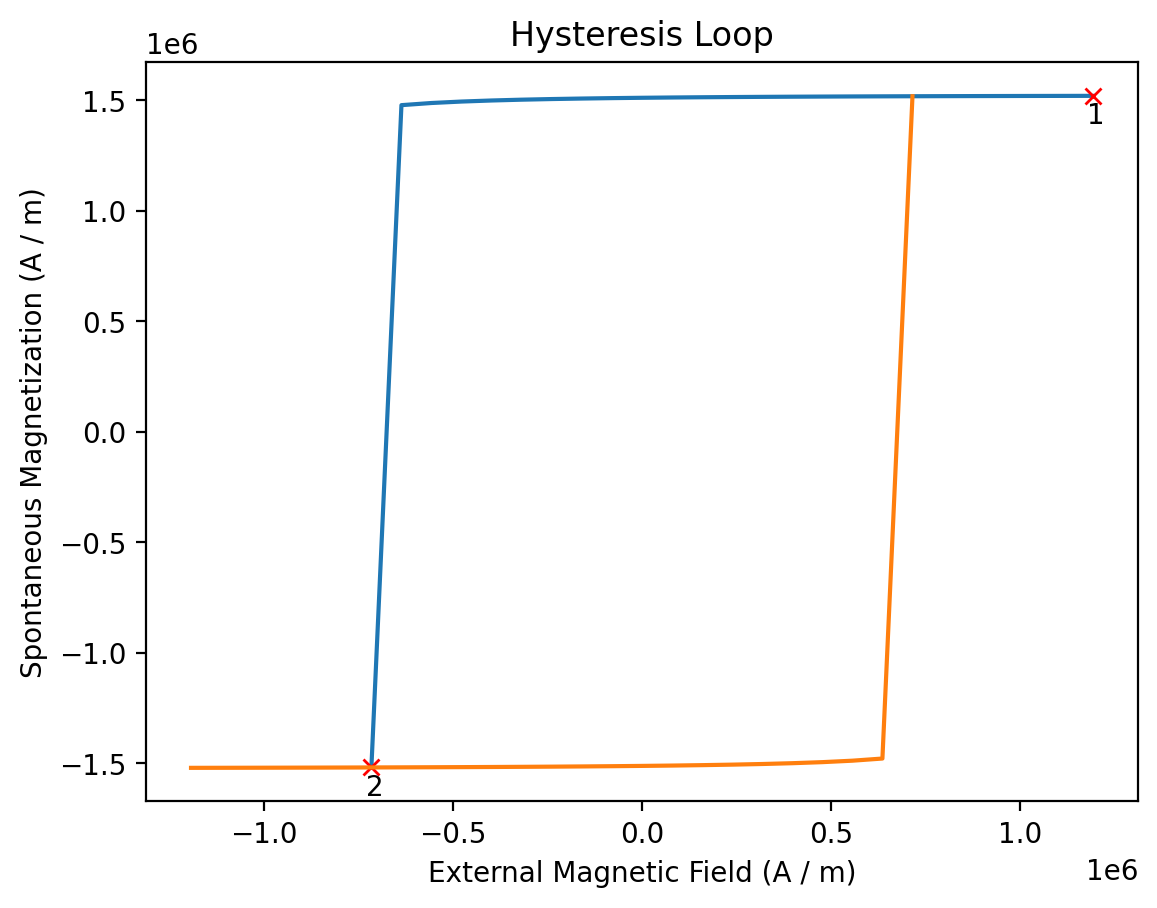

In [26]:
results_hysteresis.plot(configuration_marks=True);

In [27]:
results_hysteresis.configurations

{1: PosixPath('/home/petrocch/repo/mammos/mammos/examples/hystloop/hystloop_0001.vtu'),
 2: PosixPath('/home/petrocch/repo/mammos/mammos/examples/hystloop/hystloop_0002.vtu')}

In [28]:
results_hysteresis.plot_configuration(1);

Widget(value='<iframe src="http://localhost:42981/index.html?ui=P_0x7fa438db89d0_0&reconnect=auto" class="pyvi…

## Analyze hysteresis loop
We can extract extrinsic properties with the `extrinsic_properties` function from the `mammos_analysis` package:

In [29]:
extrinsic_properties = mammos_analysis.hysteresis.extrinsic_properties(
    results_hysteresis.H,
    results_hysteresis.M,
    demagnetization_coefficient=1 / 3,
)

In [30]:
extrinsic_properties.Hc

CoercivityHcExternal(value=675873.2267754405, unit=A / m)

In [31]:
extrinsic_properties.Mr

Remanence(value=1511984.0060448316, unit=A / m)

In [32]:
extrinsic_properties.BHmax

MaximumEnergyProduct(value=311501.3278528385, unit=J / m3)

We can combine the `results_hysteresis.plot` method with some custom code to show Hc and Mr in the hysteresis plot:

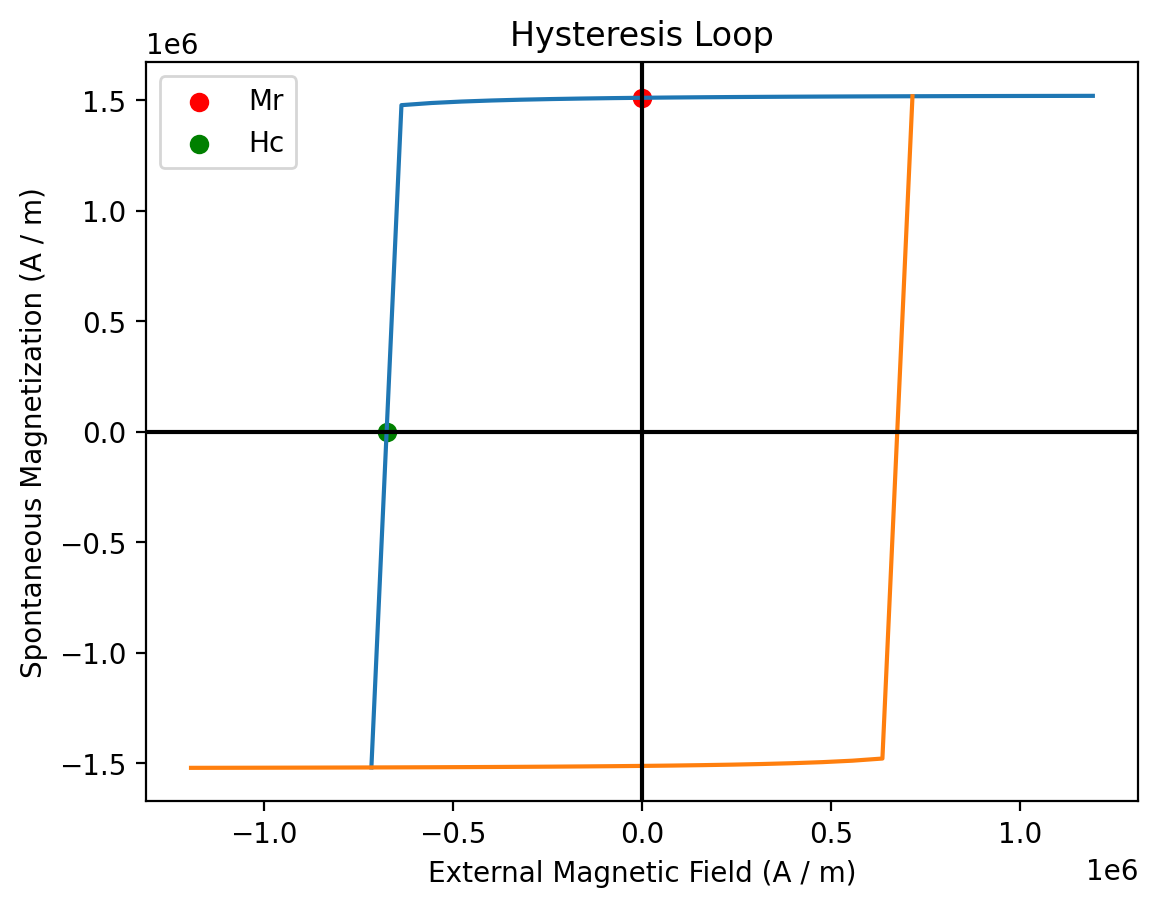

In [33]:
ax = results_hysteresis.plot()
ax.scatter(0, extrinsic_properties.Mr.value, c="r", label="Mr")
ax.scatter(-extrinsic_properties.Hc.value, 0, c="g", label="Hc")
ax.axhline(0, c="k")  # Horizontal line at M=0
ax.axvline(0, c="k")  # Vertical line at H=0
ax.legend();

## Compute Hc(T)

We can leverage mammos to calculate Hc(T) for multiple values of T.

First, we run hysteresis simulations at 7 different temperatures and collect all simulation results:

In [34]:
T = np.linspace(0, 1.1 * results_kuzmin.Tc.q, 7)

simulations = []
for temperature in T:
    print(f"Running simulation for T={temperature:.0f}")
    results_hysteresis = mammos_mumag.hysteresis.run(
        mesh_filepath=mammos_mumag.mesh.CUBE_20_nm,
        Ms=results_kuzmin.Ms(temperature),
        A=results_kuzmin.A(temperature),
        K1=results_kuzmin.K1(temperature),
        hstart=(1.5 * u.T).to(u.A / u.m),
        hfinal=(-1.5 * u.T).to(u.A / u.m),
        hnsteps=30,
    )
    simulations.append(results_hysteresis)

Running simulation for T=0 K
Running simulation for T=215 K
Running simulation for T=430 K
Running simulation for T=645 K
Running simulation for T=860 K
Running simulation for T=1074 K
Running simulation for T=1289 K


We can now use `mammos_analysis.hysteresis` as shown before to extract Hc for all simulations and visualize Hc(T):

In [35]:
Hcs = []
for res in simulations:
    cf = mammos_analysis.hysteresis.extract_coercive_field(H=res.H, M=res.M).value
    if np.isnan(cf):  # Above Tc
        cf = 0
    Hcs.append(cf)

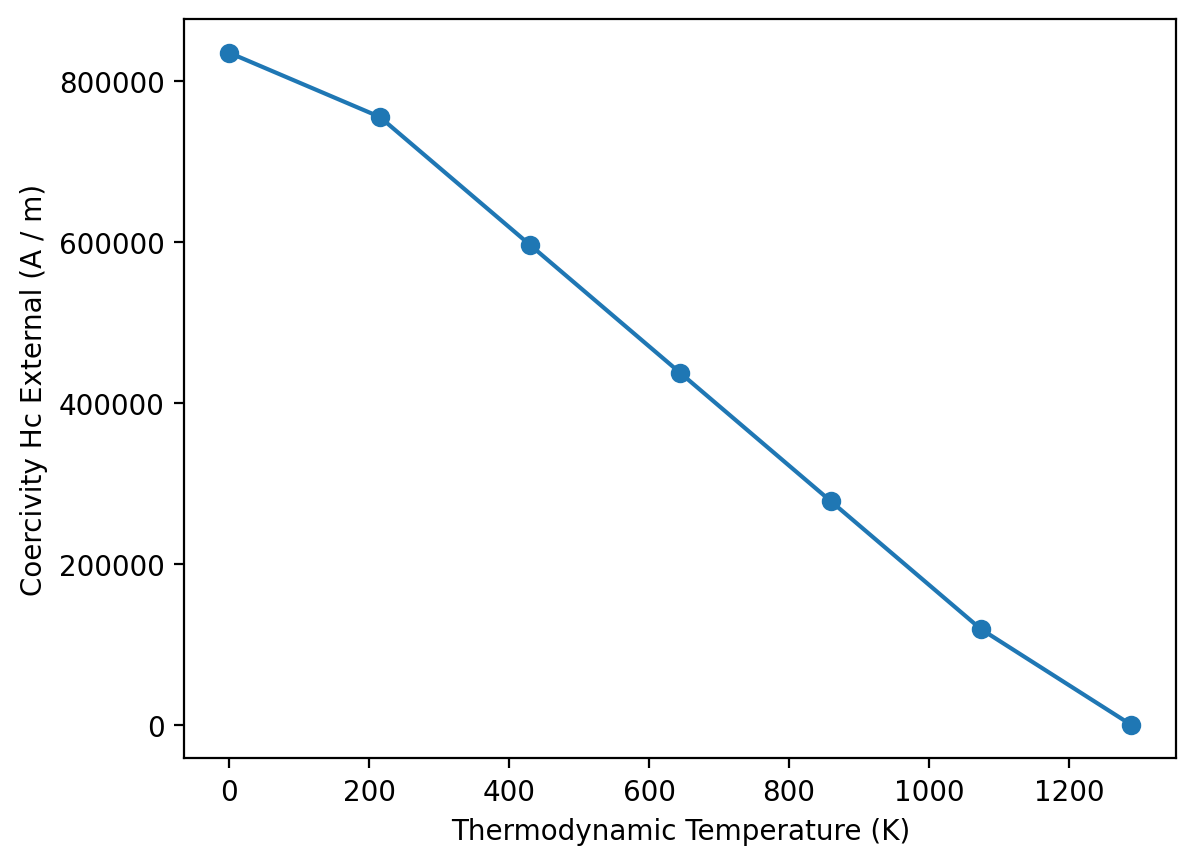

In [36]:
plt.plot(T, Hcs, linestyle="-", marker="o")
plt.xlabel(me.T().axis_label)
plt.ylabel(me.Hc().axis_label);

We can also show the hysteresis loops of all simulations:

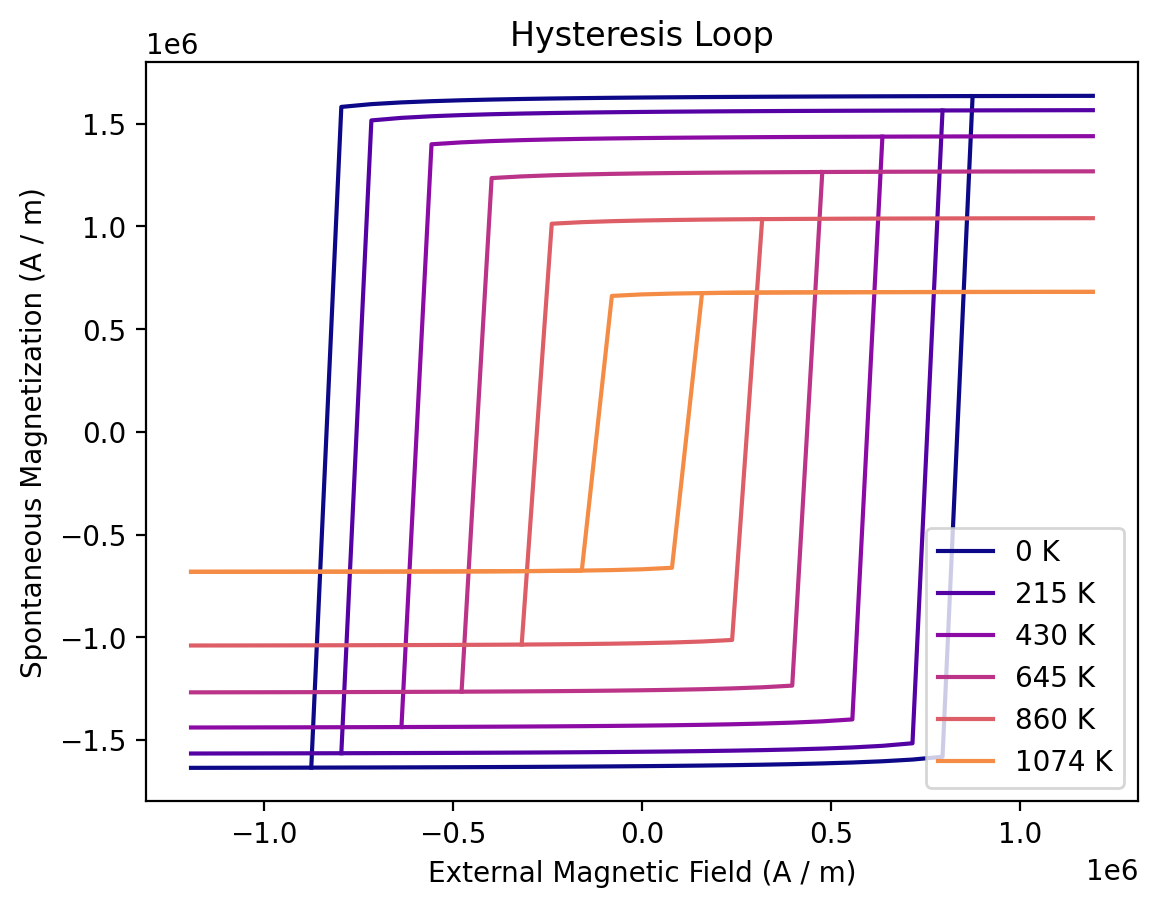

In [37]:
colors = colormaps["plasma"].colors[:: math.ceil(256 / len(T))]

fix, ax = plt.subplots()
for temperature, sim, color in zip(T, simulations, colors, strict=False):
    if np.isnan(sim.M.q).all():  # no Ms above Tc
        continue
    sim.plot(ax=ax, label=f"{temperature:.0f}", color=color, duplicate_change_color=False)
ax.legend(loc="lower right");

## MODA for the workflow
![MODA](images/hard_magnet_workflow.svg)